In [1]:
import patchseq_utils.analysis as utils
from patchseq_utils import plotting as plot
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# fix slow autocomplete
%config Completer.use_jedi = False

pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')
from importlib import reload

In [2]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [3]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [4]:
def process_df(shiny, species='mouse'):
    shiny['target_layer'] = shiny.layer.fillna('').apply(get_num)
    shiny.drop(columns=['layer'], inplace=True)

    shiny['layer_ccf'] = shiny['structure'].fillna('').apply(get_num)
    shiny['cortical_area_ccf'] = shiny['structure'].fillna('').apply(not_num)
    shiny['has_morph'] = shiny.swc_path.notna()
    shiny['has_ephys'] = shiny.nwb_path.notna()

    if species=='mouse':
        shiny['tx_qc'] = shiny.apply(lambda df:
                                            (df.Tree_call!='PoorQ') &
                                            (df.rna_amp_pass_fail == "Pass")
                                           , axis=1)
        shiny[cluster] = shiny[cluster].astype(ttypes_mouse)
        shiny['homology_type'] = shiny[cluster].map(homology_mapping_mouse).astype(homology_types)
    else:
        shiny[cluster] = shiny[cluster].astype(ttypes_human)
        shiny['homology_type'] = shiny[cluster].map(homology_mapping_human).astype(homology_types)
    return shiny



## AIBS TEa

In [5]:
shiny = pd.read_csv("~/projects/human_l1/mouse_l1_dataset_combined_2023_02_06.csv", index_col=0,
                          dtype = {'layer_ccf': str})
cluster = 't-type'
shiny[cluster] = shiny[cluster].astype(ttypes_mouse)
shiny['homology_type'] = shiny[cluster].map(homology_mapping_mouse).astype(homology_types)

In [6]:
data = shiny.join(mouse_ephys).query("failed_fx_long_squares==False")
data['cortical_area'] = data.structure.map(lambda x: x[:3])
data['cortical_area'].value_counts()

VIS    525
TEa     18
Name: cortical_area, dtype: int64

In [7]:
data.query("cortical_area=='TEa'").layer_ccf.value_counts(dropna=False)

1      13
2/3     4
NaN     1
Name: layer_ccf, dtype: int64

In [8]:
data.cortical_area.value_counts()

VIS    525
TEa     18
Name: cortical_area, dtype: int64

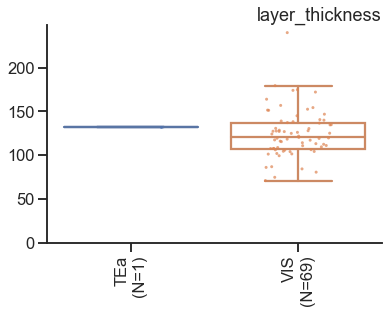

In [14]:
df = shiny.join(mouse_depth, lsuffix='_old')
df['cortical_area'] = df.structure.map(lambda x: x[:3])
df = df.query("layer=='1'")
y = "layer_thickness"
x = "cortical_area"
utils.plot_box_cluster_feature(df, y, x)

## Load mansvelder

In [48]:
shiny_df = get_shiny('mouse', nms_pass=True)

In [19]:
shiny_tea = shiny_df.loc[lambda df: df['sample_id'].str.startswith('PH')
                 & df['roi'].str.startswith('TEaL1') & (df['broad_class']=='GABAergic')
            ]
shiny_tea.shape

# shiny_tea.to_csv("/home/tom.chartrand/projects/human_l1/l1_mouse_mansvelder_shiny.csv")

(29, 110)

In [20]:
mansvelder_df = pd.read_csv("/home/tom.chartrand/projects/data/u01/mansvelder_mouse/features_E.csv", index_col=0)

tea_df = shiny_tea.join(mansvelder_df, how='inner', on='cell_name')
tea_df = process_df(tea_df)
tea_df.roi.value_counts(dropna=False)

TEaL1    16
Name: roi, dtype: int64

In [23]:
tea_df = tea_df.loc[lambda df: df[cluster].notna() & 
                    (df.cortical_area_ccf.isna() | (df.cortical_area_ccf=='TEa'))]
# drop older -70 mV holding: 10 cells
tea_df = tea_df.loc[tea_df.patch_date.map(lambda x: x.split('-')[1]).astype(int) > 7]

In [24]:
# tea_df.query('tx_qc & ~failed_fx_long_squares').to_csv(projectdir/"mansvelder_tea_2022_09_16.csv")

tea_df.query('tx_qc & ~failed_fx_long_squares').homology_type.value_counts(dropna=False)

LAMP5     7
MC4R      1
other     0
L1 VIP    0
PAX6      0
Name: homology_type, dtype: int64

## Feature significance comparisons

In [72]:
combined = pd.concat([mouse_df.loc[lambda df: df.structure.str.contains('VIS')].query(
    "layer_ccf=='1' & tx_qc & failed_qc==False"),
                      human_df.query("collaborator=='AIBS' & layer=='1' & failed_fx_long_squares==False")],
                    sort=False).dropna(subset=['homology_type'])

In [73]:
combined.species.value_counts()

mouse    212
human    177
Name: species, dtype: int64

In [74]:
variable = 'cortical_area'
features = data.groupby(variable)[ephys_features].apply(
    lambda x: x.notna().mean(axis=0)).min().loc[lambda x: x>0.5].index
metric='mw_r'
pval='pval_mw_fdr'
labels = {x: feature_name(x) for x in features}

Text(0.5, 0, 'r')

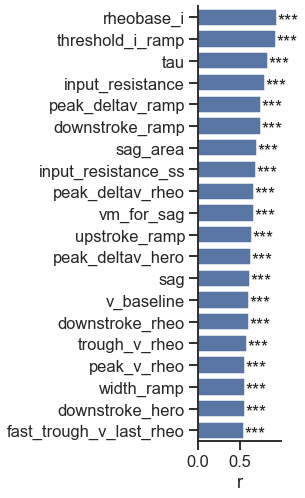

In [75]:
results = utils.run_twosamp(combined, features, 'species').sort_values(metric, ascending=False)
utils.plot_feature_effect_sizes(results, pval=pval, val=metric)
plt.xlabel('r')
# plt.title('Cohens D')

In [76]:
corr = combined[ephys_features].corr()
df = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack()
df.loc[lambda x: np.abs(x)>0.8]

width_short_square              width_suprathresh_short_square    0.836087
upstroke_short_square           downstroke_short_square          -0.829379
                                peak_deltav_short_square          0.822747
                                upstroke_ramp                     0.819520
                                upstroke_rheo                     0.841307
                                upstroke_hero                     0.908598
peak_deltav_short_square        peak_deltav_ramp                  0.811058
                                peak_deltav_rheo                  0.804061
                                peak_deltav_hero                  0.877000
threshold_v_ramp                trough_v_ramp                     0.810334
                                threshold_v_rheo                  0.844219
                                threshold_v_hero                  0.828392
width_ramp                      width_suprathresh_ramp            0.997238
upstroke_ramp            

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


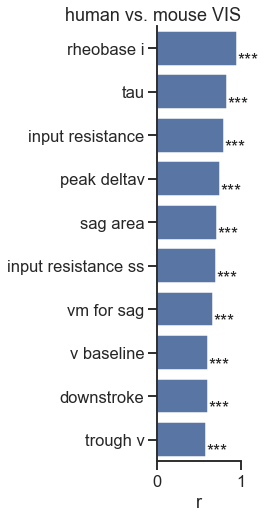

In [91]:
top_feat = utils.select_distinct(results.index, corr, threshold=0.8)
utils.plot_feature_effect_sizes(results.loc[top_feat], ylabels=labels, pval=pval, val=metric)
plt.title('human vs. mouse VIS', loc='right')
plt.xlim(0, 1)
plt.xlabel('r')
plt.tight_layout()
save_plot_multiple(figdir/"f3_areas_vis", ['pdf','svg'])

## TEa combined

In [78]:
combined_tea = pd.concat([
    tea_df.query('tx_qc & failed_fx_long_squares==False'),
   mouse_df.query("cortical_area_ccf=='TEa' & layer_ccf=='1' & tx_qc & failed_fx_long_squares==False"),
  human_df.query("collaborator=='AIBS' & layer=='1' & failed_fx_long_squares==False")
                         ],
                    sort=False).dropna(subset=['homology_type'])
combined_tea.species.value_counts()

human    177
mouse     18
Name: species, dtype: int64

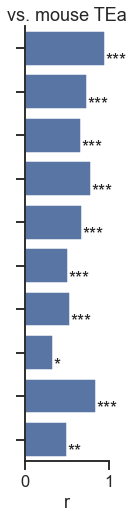

In [92]:
results_tea = utils.run_twosamp(combined_tea, features, 'species')
utils.plot_feature_effect_sizes(results_tea.loc[top_feat], ylabels=labels, pval=pval,
                                val=metric, sort=False)
plt.title('vs. mouse TEa')
plt.xlim(0, 1)
plt.xlabel('r')
plt.gca().set_yticklabels([]);
save_plot_multiple(figdir/"f3_areas_tea", ['pdf','svg'])

Text(0.5, 1.0, 'AIBS TEa comparison')

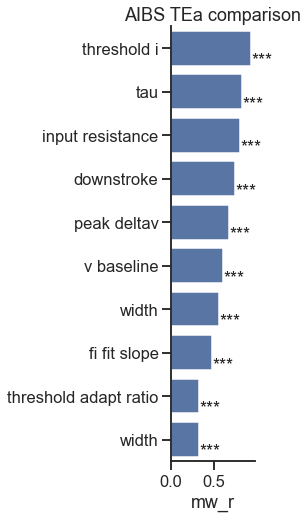

In [67]:
combined_tea = pd.concat([data.loc[ lambda df: df['cortical_area']=='TEa'],
                      human_df.loc[ lambda df: df['layer_lims']=='1']],
                    sort=False)
metric='mw_r'
pval='pval_mw_fdr'
results_tea = utils.run_twosamp(combined_tea, features, 'species').sort_values(metric, ascending=False)
top_feat = utils.select_distinct(results_tea.index, corr, threshold=0.8)
utils.plot_feature_effect_sizes(results.loc[top_feat], ylabels=labels, pval=pval, val=metric)
plt.title('AIBS TEa comparison')